# First problem

In the article [1] we can see an example of tensor in figure 4. The construction of this tensor is described there. They try to compute a non-negative CPD for this tensor in this article. This is possible since the figure can be considered as having only $0$'s and $1$'s. 

Here we will construct the same tensor and use the *cpd* function with $R = 50$ to computes its CPD. This value of $R$ is suggested in the same article.


[1] *Non-Negative Tensor Factorization with Applications to Statistics and Computer Vision* - A. Shashua and T. Hazan 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import TensorFox as tfx

In [2]:
# Load the tensor T, which has shape 256 x 32 x 32. 
T = np.load('swimmer.npy')
m, n, p = T.shape
Tsize = np.linalg.norm(T)

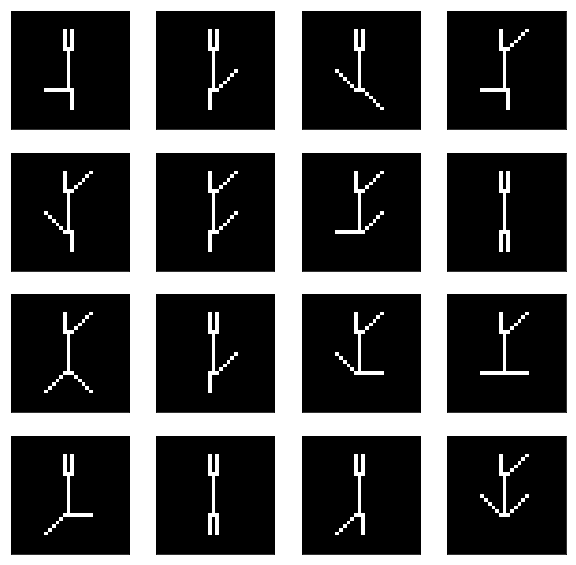

In [3]:
# Visualize some frames, i.e., some frontal slices of the tensor.
num_rows = 4
num_cols = 4    
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10), sharex='col', sharey='row')     
for i in range(num_rows):
    for j in range(num_cols):
        s = np.random.randint(0,m)
        ax[i,j].xaxis.set_major_locator(plt.NullLocator())
        ax[i,j].yaxis.set_major_locator(plt.NullLocator())
        ax[i,j].imshow(-T[:,:,s], cmap='gray')

In [4]:
# Compute the CPD of T, assuming T has rank 50. 
class options:
    display = 1
    initialization = 'smart_random'
    
R = 50
factors, T_approx, output = tfx.cpd(T, R, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (256, 32, 32) to (13, 15, 23)
-----------------------------------------------------------------------------------------------
Type of initialization: smart_random
-----------------------------------------------------------------------------------------------
Computing CPD
Final results
    Number of steps = 106
    Relative error = 0.0006082636436528761
    Accuracy =  99.93917 %


# Analyzing and visualizing the solution

The solution above can be considered as satisfactory since the relative error is of order $O(10^{-4})$. Notice that the error associated to the starting point is close to $0.16$. The remarkable thing here is the compression, which greatly reduced the tensor without losing precision (the error after compressing is of order $O(10^{-14})$).  

Now let's plot the evolution of the relative errors and its consecutive differences through the iterations.
In $log_{10}$ scale we can see that the convergence is linear. This is a nice property to have, it indicates the rate of convergence is reasonably fast. After that we plot the evolution of the step sizes at each iteration and finally the size of the gradient at each iteration. We expect that both converges to $0$.

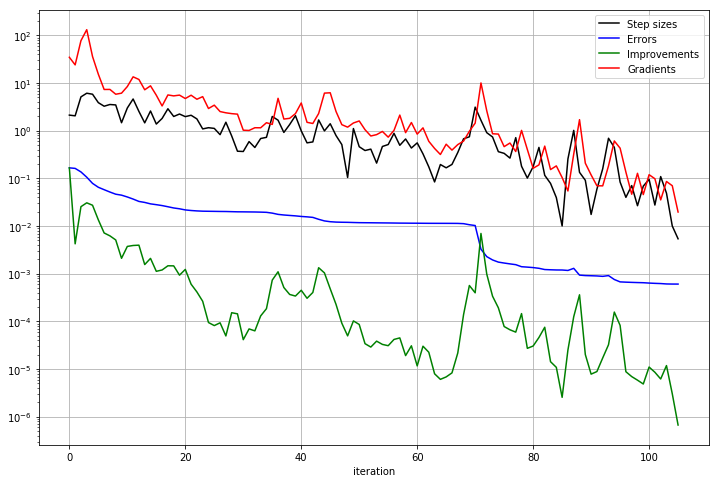

In [5]:
# The outputs step_sizes, errors, errors_diff and gradients are plotted together below
# We put both stages (main and refinement) in the same plot.
plt.figure(figsize=[12,8])

# We divide the arrays of errors by the norm of T to obtain values associated to the relative errors.
Tsize = np.linalg.norm(T)

# a is the size of the arrays of the main stage and b is the size of the arrays of the refinement stage.
a = output.step_sizes[0].size

# Step sizes
plt.plot(np.arange(a), output.step_sizes[0],'k-' , markersize=2, label='Step sizes')

# Errors
plt.plot(np.arange(a), output.errors[0],'b-' , markersize=2, label='Errors')

# Errors diff
plt.plot(np.arange(a), output.improv[0], 'g-', markersize=2, label='Improvements')

# Gradients
plt.plot(np.arange(a), output.gradients[0], 'r-', markersize=2, label='Gradients')

plt.xlabel('iteration')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

Below we show some slices of our computed tensor. We show the same slices plotted before so we can compare them. As we can see, it is almost impossible to notice some difference just by looking. The computed CPD is a success!

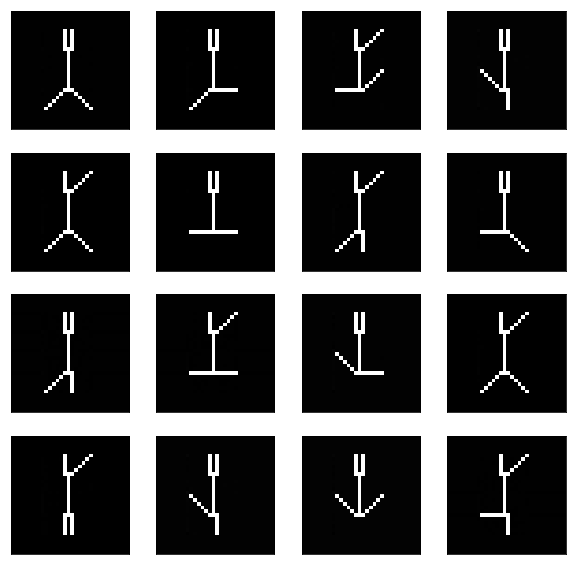

In [6]:
# Visualize some frames, i.e., some frontal slices of the approximate tensor.
num_rows = 4
num_cols = 4    
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10), sharex='col', sharey='row')     
for i in range(num_rows):
    for j in range(num_cols):
        s = np.random.randint(0,m)
        ax[i,j].xaxis.set_major_locator(plt.NullLocator())
        ax[i,j].yaxis.set_major_locator(plt.NullLocator())
        ax[i,j].imshow(-T_approx[:,:,s], cmap='gray')

Remember we can write $T \approx \sum_{r=1}^R X_r \otimes Y_r \otimes Z_r$. In other words, we can write $T$ as a sum of $R$ ($R = 50$ in this case) rank one tensors. Each rank one tensor can be considered as a fundamental block of $T$ so it is interesting sometimes to know how these fundamental blocks are. For each $r = 1 \ldots R$, $X_r \otimes Y_r \otimes Z_r$ is a tensor of same shape as $T$ and we can visualize its slices just as we did for $T$. This can bring some insight about the decomposition just computed.

The function **rank1_plot** was constructed with this situation in mind. Just choose some slice $s$, where $0 \leq s \leq 255$ and use the command

                           tf.rank1_plot(X, Y, Z, m, n, R, k=s).
 

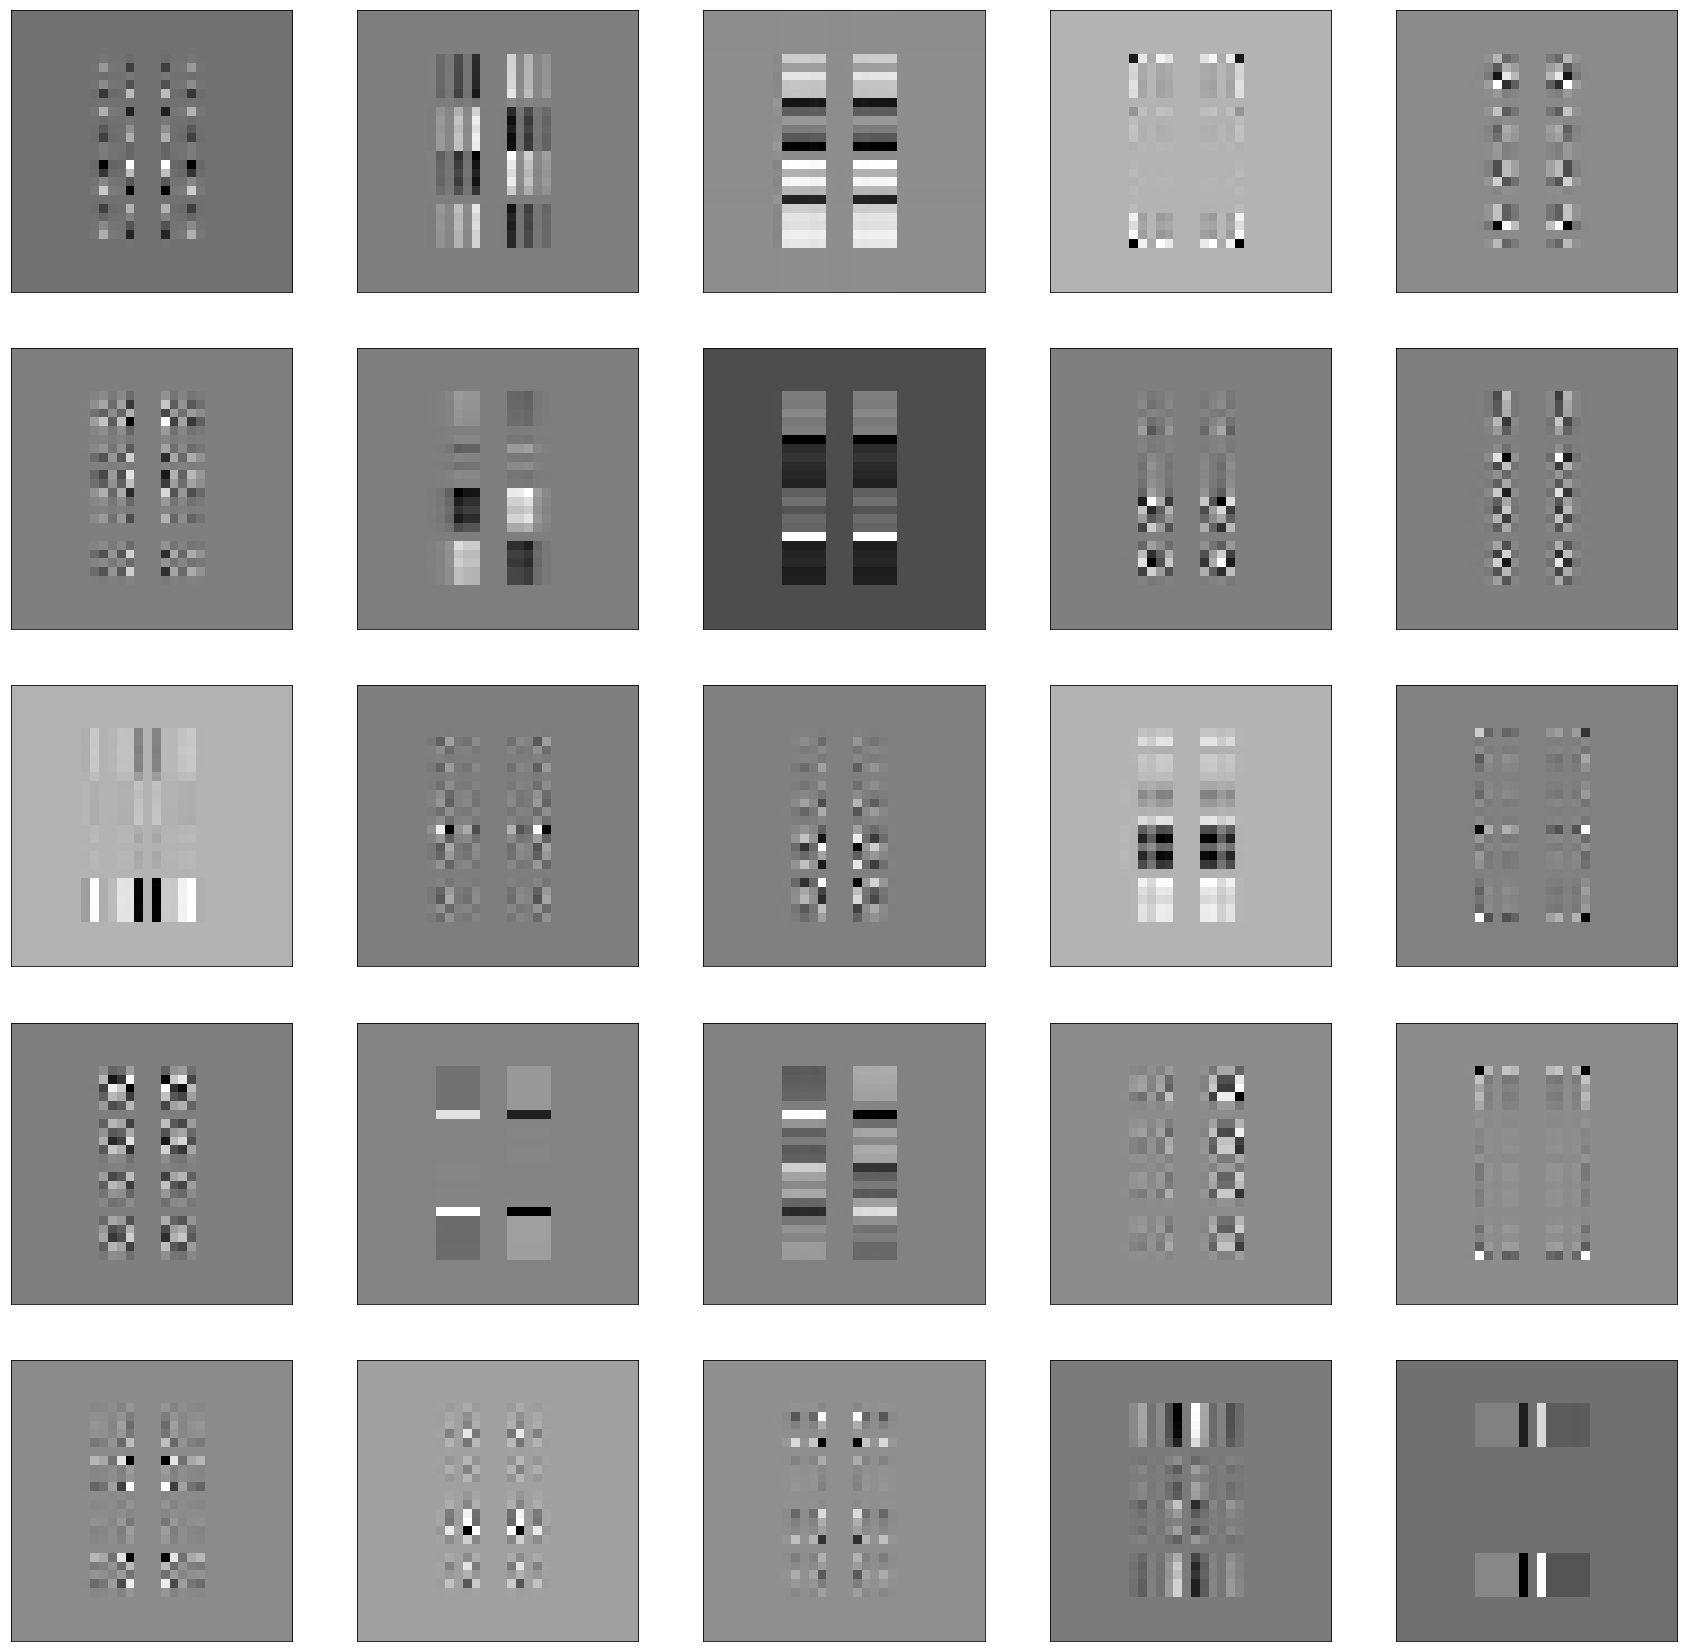

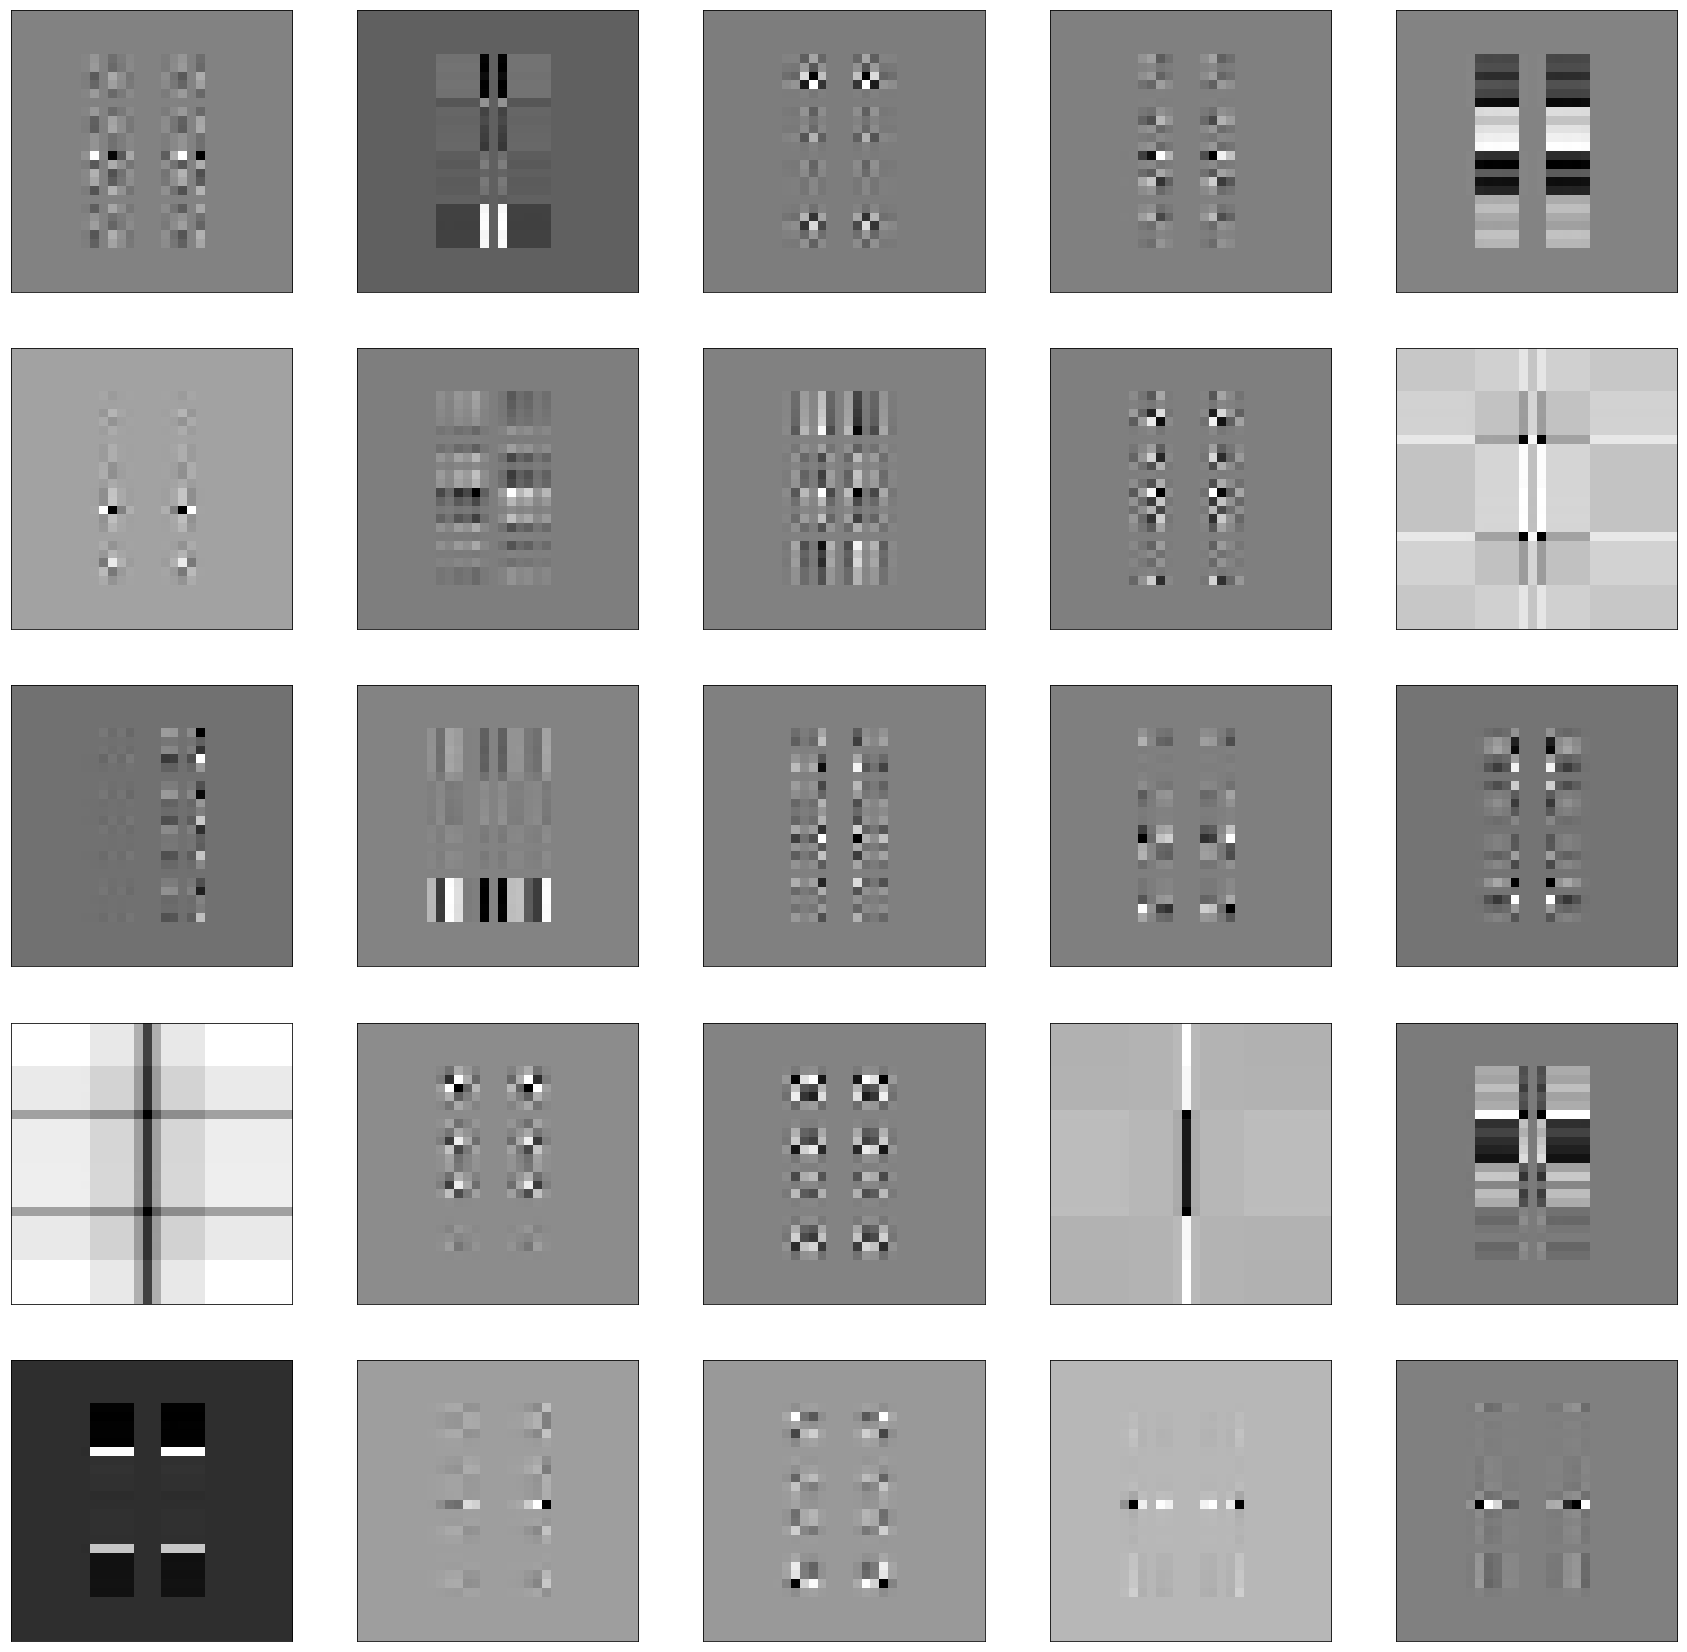

In [7]:
Lambda, factors = tfx.cnv.normalize(factors)
X = factors[0]
Y = factors[1]
Z = factors[2]
tfx.disp.rank1_plot(X, Y, Z, m, n, R, k=0)

To finish, we may have noted that the computation of this CPD is not always good. Sometimes we need to repeat the computation to get a good CPD. For this problem in particular we can use the function *stats* to see how is the distribution of the solutions given the default parameters.

[====================================================================================================] 100.0%

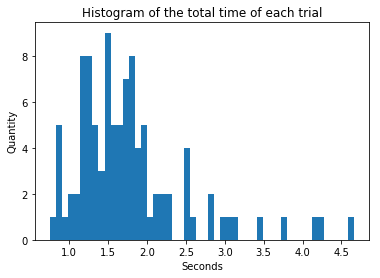

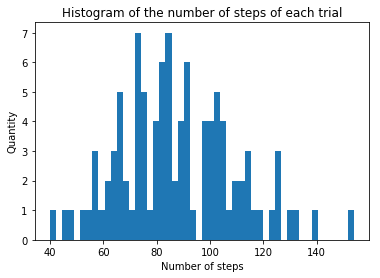

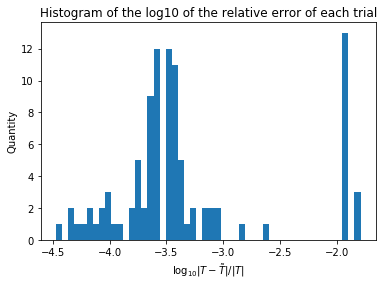

In [8]:
# We keep the initialization as smart_random but suppress the display options.
options.display = 0
times, steps, rel_errors = tfx.stats(T, R, options)

In [9]:
print('E[seconds] =', times.mean())
print()
print('E[number of steps] =', int(steps.mean()))
print()
print('E[relative error] =', rel_errors.mean())

E[seconds] = 1.778092803955078

E[number of steps] = 87

E[relative error] = 0.0022434657328256422


From the histograms we see that the computational time concentrates around $1.7$ seconds (on my humble laptop), the number of steps concentrates around $87$ and the error concentrates around $-3.5$ (in $log_{10}$ scale). It is not hard to guess we can have an error of order $O(10^{-4})$ if we try to compute a few CPDs.